In [0]:
#!pip install --upgrade tensorflow-gpu==2.1.0rc0 tensorflow==2.1.0rc0

In [0]:
 %tensorflow_version 2.x

In [26]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import imgaug as ia
from imgaug import augmenters as iaa

from datetime import datetime

import csv
import os
import re
import math

import h5py

#tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.1.0-rc1


In [27]:
# Mount the google drive folder with the data
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Paths of the data
DATASET_PATH    = '/content/drive/My Drive/retina_images/'
CHECKPOINT_PATH = DATASET_PATH + '/checkpoints/'
DATA_SRC_PATH   = DATASET_PATH + '/data/'

TEMP_PATH       = '/content/'
DATA_PATH       = TEMP_PATH + '/data/'

In [0]:
# unzip the .zip files to the local /content/data of the notebook
# !unzip -q -n -d '{DATA_PATH}' '{DATASET_PATH+"/train_dst.zip"}'
# !unzip -q -n -d '{DATA_PATH}' '{DATASET_PATH+"/test_dst.zip"}'

In [30]:
!dir '{DATA_PATH}/train_dst' | head
!dir '{DATA_PATH}/test_dst' | head

10003_left.jpeg   19968_left.jpeg   30000_left.jpeg   39972_right.jpeg
10003_right.jpeg  19968_right.jpeg  30000_right.jpeg  39975_left.jpeg
10007_left.jpeg   19970_left.jpeg   30004_left.jpeg   39975_right.jpeg
10007_right.jpeg  19970_right.jpeg  30004_right.jpeg  39978_left.jpeg
10009_left.jpeg   19972_left.jpeg   3000_left.jpeg    39978_right.jpeg
10009_right.jpeg  19972_right.jpeg  3000_right.jpeg   39981_left.jpeg
1000_left.jpeg	  19975_left.jpeg   30012_left.jpeg   39981_right.jpeg
1000_right.jpeg   19975_right.jpeg  30012_right.jpeg  39982_left.jpeg
10010_left.jpeg   19976_left.jpeg   30015_left.jpeg   39982_right.jpeg
10010_right.jpeg  19976_right.jpeg  30015_right.jpeg  39983_left.jpeg
10000_left.jpeg   19996_right.jpeg  29928_right.jpeg  39921_right.jpeg
10000_right.jpeg  19997_left.jpeg   29930_left.jpeg   39922_left.jpeg
10001_left.jpeg   19997_right.jpeg  29930_right.jpeg  39922_right.jpeg
10001_right.jpeg  19998_left.jpeg   29931_left.jpeg   39923_left.jpeg
10002_right.jp

In [0]:
#!apt-get install libimage-size-perl

In [0]:
#!imgsize '/content/data/train_dst/10003_left.jpeg'

In [33]:
!curl https://raw.githubusercontent.com/tensorflow/addons/5f9f36c03a5b132da4fe447dfa9df472ab7ea0df/tensorflow_addons/metrics/cohens_kappa.py -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7223  100  7223    0     0  30476      0 --:--:-- --:--:-- --:--:-- 30476


In [34]:
%%writefile cohens_kappa_fix.patch
--- cohens_kappa.py	2019-12-30 19:47:55.000745582 +0100
+++ cohens_kappa_fix.py	2019-12-30 19:50:25.117155527 +0100
@@ -115,9 +115,10 @@
         y_true = tf.cast(y_true, dtype=tf.int64)
         y_pred = tf.cast(y_pred, dtype=tf.int64)
 
-        if y_true.shape != y_pred.shape:
-            raise ValueError(
-                "Number of samples in `y_true` and `y_pred` are different")
+        tf.debugging.assert_equal(
+            tf.shape(y_true),
+            tf.shape(y_pred),
+            message="Number of samples in `y_true` and `y_pred` are different")
 
         # compute the new values of the confusion matrix
         new_conf_mtx = tf.math.confusion_matrix(

Overwriting cohens_kappa_fix.patch


In [35]:
!echo "" >> cohens_kappa_fix.patch
!patch cohens_kappa.py < cohens_kappa_fix.patch

patching file cohens_kappa.py


In [36]:
%run -i cohens_kappa.py

ValueError: ignored

# ResNet-50 architecture
### Identity Block

In [0]:
# Build the identity block
class IdentityBlock():
  def __init__(self, kernel_size, filters, name, **kwargs):
    '''
      kernel_size: (tuple) size of the filter (kernel)
      filters: number of filters (kernels)
      name: base name for the block
    '''

    self.kernel_size = kernel_size
    self.filters = filters
    self.expansion = 4
    self.name = name

    self.__build()
  
  def __build(self):
    base_name = 'conv'+str(self.name['layer'])+'_block'+str(self.name['inner'])+'_'

    self.conv1 = layers.Conv2D(self.filters, (1, 1), name=base_name+'1_conv')
    self.bn1 = layers.BatchNormalization(name=base_name+'1_bn')
    self.relu1 = layers.Activation('relu', name='activation_'+str(self.name['activation']))

    self.conv2 = layers.Conv2D(self.filters, self.kernel_size, padding='same', name=base_name+'2_conv')
    self.bn2 = layers.BatchNormalization(name=base_name+'2_bn')
    self.relu2 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 1))

    self.conv3 = layers.Conv2D(self.filters*self.expansion, (1, 1), name=base_name+'3_conv')
    self.bn3 = layers.BatchNormalization(name=base_name+'3_bn')
    self.relu3 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 2))


  def __call__(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.conv3(x)
    x = self.bn3(x)

    x = layers.add([x, input_tensor], name=self.name['merge'])
    return self.relu3(x)

## Convolutional Block

Expands the input depth through a 1x1 convolution to allow the addition with the output of the block

In [0]:
# Build the conv block
class ConvBlock():
  def __init__(self, kernel_size, filters, name, strides=(2, 2), **kwargs):
    '''
      kernel_size: (tuple) size of the filter (kernel)
      filters: number of filters (kernels)
      name: base name for the block
      strides: (tuple) with the size of the stride 
    '''

    self.kernel_size = kernel_size
    self.filters = filters
    self.strides = strides
    self.expansion = 4
    self.name = name
    self.__build()


  def __build(self):
    base_name = 'conv'+str(self.name['layer'])+'_block'+str(self.name['inner'])+'_'

    self.conv1 = layers.Conv2D(self.filters, (1, 1), strides=self.strides, name=base_name+'1_conv')
    self.bn1 = layers.BatchNormalization(name=base_name+'1_bn')
    self.relu1 = layers.Activation('relu', name='activation_'+str(self.name['activation']))

    self.conv2 = layers.Conv2D(self.filters, self.kernel_size, padding='same', name=base_name+'2_conv')
    self.bn2 = layers.BatchNormalization(name=base_name+'2_bn')
    self.relu2 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 1))

    self.conv3 = layers.Conv2D(self.filters*self.expansion, (1, 1), name=base_name+'3_conv')
    self.bn3 = layers.BatchNormalization(name=base_name+'3_bn')
    self.relu3 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 2))

    self.shortcut_conv = layers.Conv2D(self.filters*self.expansion, (1, 1), strides=self.strides, name=base_name+'0_conv')
    self.shortcut_bn = layers.BatchNormalization(name=base_name+'0_bn')


  def __call__(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.conv3(x)
    x = self.bn3(x)

    shortcut = self.shortcut_conv(input_tensor)
    shortcut = self.shortcut_bn(shortcut)

    x = layers.add([x, shortcut], name=self.name['merge'])
    return self.relu3(x)

## Build the full network

In [0]:
# Build the ResNet
class ResNet():
  def __init__(self, classes=5):
    '''
      classes: number of output classes
    '''
    
    self._layers = []
    self.classes = classes
    
    # According to paper (ResNet-50)
    self.n_layers = [3, 4, 6, 3]
    self.filters = 64

  def __build(self):
    filters = [64, 128, 256, 512]
    
    # for naming purposes
    merge = 1
    activation = 2
    
    # head
    self._layers.append(layers.ZeroPadding2D(padding=(3, 3), name='head_padding1'))
    self._layers.append(layers.Conv2D(self.filters, (7, 7), strides=(2, 2), padding='valid', name='conv1_conv'))
    self._layers.append(layers.BatchNormalization(name='conv1_bn'))
    self._layers.append(layers.Activation('relu', name='activation_1'))
    self._layers.append(layers.ZeroPadding2D(padding=(1, 1), name='head_padding2'))
    self._layers.append(layers.MaxPooling2D((3, 3), strides=(2, 2), name='maxpooling'))

    # blocks
    for i, l in enumerate(self.n_layers):
      for j in range(l):
        name = {
            'layer': i+2,
            'inner': j+1,
            'merge': 'merge_'+str(merge),
            'activation': activation
        }

        if i == 0 and j == 0:
          self._layers.append(ConvBlock((3, 3), filters[i], strides=(1, 1), name=name))
        elif j == 0:
          self._layers.append(ConvBlock((3, 3), filters[i], name=name))
        else:
          self._layers.append(IdentityBlock((3, 3), filters[i], name=name))
        
        merge += 1
        activation +=3

    self._layers.append(layers.GlobalAveragePooling2D(name='avg_pool'))
    # self._layers.append(layers.Dense(self.classes, activation='softmax', name='fc'))

  def __call__(self, input_tensor):
    self.__build()

    for i, _layer in enumerate(self._layers):
      if i == 0:
        x = _layer(input_tensor)
      else:
        x = _layer(x)

    return keras.Model(input_tensor, x, name='resnet-50')

In [0]:
# function to load the pretrained weights onto the custom model
def transfer_weights(model):
  '''
    model: keras model to transfer the weights (must be resnet-50)
  '''
  trained = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=model.input.shape, pooling='avg', classes=5)

  for i, layer in enumerate(trained.layers):
    if len(layer.weights) > 0 and layer.name is not 'probs':
      weights = layer.get_weights()
      model.get_layer(layer.name).set_weights(weights)
  
  model.save_weights('/content/drive/My Drive/retina_images/pretrained/resnet50_weights_imagenet_no_dense.h5', overwrite=True)

In [0]:
# generates a model for regression
def generate_model(model=None, classes=5, shape=(512, 512, 3)):
  '''
    model: keras model
    classes: number of output classes
    shape: tuple like shape of the input
  '''
  
  input = keras.Input(shape=shape)
  
  if model is None:
    model = ResNet(classes=classes)(input)

  x = layers.Dropout(0.5)(model.output)
  x = layers.Dense(1, activation='linear')(x)

  return keras.Model(model.input, x)

In [69]:
# Display model layers
#model = ResNet(classes=5)(keras.Input(shape=(384, 384, 3)))
# model = keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#transfer_weights(model)
#model.load_weights(f'{DATASET_PATH}pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
head_padding1 (ZeroPadding2D)   (None, 390, 390, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 192, 192, 64) 9472        head_padding1[0][0]              
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Data preparation

In [43]:
train_labels = pd.read_csv(f'{DATASET_PATH}train_labels.csv')
test_labels = pd.read_csv(f'{DATASET_PATH}test_labels.csv')

classes = [0, 1, 2, 3, 4]

# Remove usage column
test_labels = test_labels.drop('Usage', axis=1)

train_labels['image'] = train_labels['image'].apply(lambda f: f'train_dst/{f}.jpeg')
test_labels['image'] = test_labels['image'].apply(lambda f: f'test_dst/{f}.jpeg')

data = pd.concat([train_labels, test_labels]).sample(frac=1, random_state=97309938)
data = data.dropna()

data

,image,level
18337,train_dst/23095_right.jpeg,3
13617,test_dst/11328_right.jpeg,2
15616,test_dst/12957_left.jpeg,0
32626,test_dst/27055_left.jpeg,0
9066,train_dst/11378_left.jpeg,0
...,...,...
42352,test_dst/35006_left.jpeg,0
31559,test_dst/26161_right.jpeg,0
35946,test_dst/29747_left.jpeg,0
10115,train_dst/12739_right.jpeg,2


### Visualization of the number of data per class

([<matplotlib.axis.XTick at 0x7f12e3eaab70>,
 <a list of 5 Text xticklabel objects>)

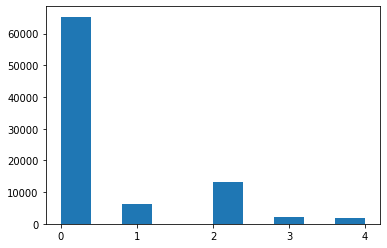

In [44]:
plt.hist(x=data['level'])
plt.xticks(classes)

# Normal training split

In [0]:
split = int(len(data) * 0.15)
test_df = data.iloc[:split].copy().reset_index(drop=True)
train_df = data.iloc[split:].copy()

train_c0 = train_df[train_df['level'] == 0]
train_c0 = train_c0.iloc[:int(len(train_c0)*0.25)]
train_cP = train_df[train_df['level'] > 0]

train_df = pd.concat([train_c0, train_cP]).sample(frac=1, random_state=69859680).reset_index(drop=True) # concat & shuffle data


# High definition training split

In [0]:
# newdata = None

# for class_ in classes:
#   values = data.where(data['level'] == class_).dropna() 
#   if class_ == 0:
#     newdata = values.iloc[:int(len(values) * 0.05)]
#   else:
#     newdata = pd.concat([newdata, values.iloc[:int(len(values) * 0.2)]])

# split = int(len(newdata) * 0.1)
# test_df = newdata.iloc[:split].copy()
# train_df = newdata.iloc[split:].copy()

### New distribution for training

([<matplotlib.axis.XTick at 0x7f12e399e748>,
 <a list of 5 Text xticklabel objects>)

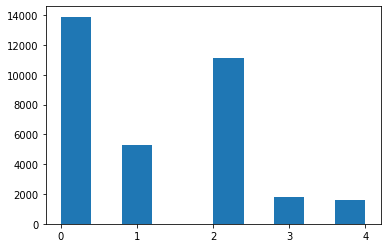

In [47]:
plt.hist(x=train_df['level'])
plt.xticks(classes)

In [0]:
 aug_seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Flipud(0.5),
  iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Crop(percent=(0.01, 0.1), sample_independently=False)), # crop image equally on both sides
  ]),
  iaa.Multiply((0.9, 1.5))
], random_order=True)

In [49]:
BATCH_SIZE = 32
IMG_SIZE = 384
 
datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda img: np.clip(aug_seq.augment_image(img) / 255.0, 0, 1))

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

validation_generator = datagen.flow_from_dataframe(
    dataframe=test_df.iloc[:len(test_df)//3],
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

Found 33624 validated image filenames.
Found 4424 validated image filenames.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 76 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 11 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
# vanilla imagenet weights
imagenet_weights = f'{DATASET_PATH}pretrained/resnet50_weights_imagenet_no_dense.h5'
# weights of first training
diabetic_regression_weights = f'{DATASET_PATH}checkpoints/resnet50_dense_regression.h5'
# weights of the last training with 384x384 images
checkpoint_path = f'{DATASET_PATH}checkpoints/resnet50_dense_regression_checkpoint_384.h5'
# weights of las training with 512x512 images
checkpoint_high_path = f'{DATASET_PATH}checkpoints/resnet50_dense_regression_checkpoint_512.h5'
# last checkpoint
last_checkpoint = f'{DATASET_PATH}checkpoints/resnet50_dense_regression_last_384_final.h5'

# Training for multi label classification

In [0]:
# model = ResNet(classes=5)(keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
# model.load_weights(imagenet_weights)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])
# model.fit(train_generator,
#           epochs=10,
#           validation_data=validation_generator,
#           max_queue_size=16,
#           workers=4, use_multiprocessing=False)

# Training for regression

In [0]:
class HistoryLogger(keras.callbacks.Callback):
  def __init__(self, prefix):
    super(HistoryLogger, self).__init__()

    self.prefix = prefix
    self.history = {}

  def on_epoch_begin(self, epoch, logs={}):
    self.history = {}

  def on_epoch_end(self, epoch, logs={}):
    df = pd.DataFrame.from_dict(self.history)
    df.to_hdf(f'{DATASET_PATH}/history/{self.prefix}.hdf5', key=f'E{epoch}', mode='a')

    hist = {}
    for k, v in logs.items():
      hist.setdefault(k, []).append(v)

    df = pd.DataFrame.from_dict(hist)
    df.to_hdf(f'{DATASET_PATH}/history/{self.prefix}.hdf5', key=f'VAL_E{epoch}', mode='a')

  def on_batch_end(self, batch, logs={}):
    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)


def lr_schedule(epoch, alpha):
  decay = (1 - (epoch / float(10))) ** 2
  alpha = 0.000001 * decay

  return float(alpha)

class KappaMetric(CohenKappa):
    def __init__(self):
      super().__init__(num_classes=5, weightage='quadratic')

    @staticmethod
    def classify(x):
      return tf.case(
          [(tf.less(x, 0.5), lambda: 0.0),
           (tf.less(x, 1.5), lambda: 1.0),
           (tf.less(x, 2.5), lambda: 2.0),
           (tf.less(x, 3.5), lambda: 3.0)],
          default=lambda: 4.0, exclusive=False)

    def update_state(self, y_true, y_pred, sample_weight=None):
      t = tf.reshape(y_true, shape=[-1])
      p = tf.map_fn(KappaMetric.classify, y_pred)
      
      super().update_state(t, p, sample_weight)

# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint(f'{DATASET_PATH}checkpoints/resnet50_dense_regression_last_384_5.h5', verbose=1, save_best_only=True, save_weights_only=True)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
hs_callback = HistoryLogger(f'from_imagenet_history_full_384_5')

model = ResNet(classes=5)(keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model = generate_model(model, 5, (IMG_SIZE, IMG_SIZE, 3))
model.load_weights(f'{DATASET_PATH}checkpoints/resnet50_dense_regression_last_384_5.h5')

In [59]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000001), loss='mse', metrics=['mae', 'accuracy', KappaMetric()])
model.fit(train_generator,
          epochs=5,
          validation_data=validation_generator,
          callbacks=[checkpoint, hs_callback],
          max_queue_size=16,
          workers=4, use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1051 steps, validate for 139 steps
Epoch 1/5
1050/1051 [============================>.] - ETA: 0s - loss: 0.3771 - mae: 0.4765 - accuracy: 0.3947 - cohen_kappa: 0.8153
Epoch 00001: val_loss improved from inf to 0.37930, saving model to /content/drive/My Drive/retina_images/checkpoints/resnet50_dense_regression_last_384_5.h5
1051/1051 [==============================] - 589s 561ms/step - loss: 0.3770 - mae: 0.4765 - accuracy: 0.3948 - cohen_kappa: 0.8153 - val_loss: 0.3793 - val_mae: 0.4647 - val_accuracy: 0.5615 - val_cohen_kappa: 0.7483
Epoch 2/5
1050/1051 [============================>.] - ETA: 0s - loss: 0.3588 - mae: 0.4588 - accuracy: 0.4057 - cohen_kappa: 0.8248
Epoch 00002: val_loss did not improve from 0.37930
1051/1051 [==============================] - 581s 552ms/step - loss: 0.3591 - mae: 0.4589 - accuracy: 0.4056 - cohen_kappa: 0.8246 - val_loss: 0.3866 - val_mae: 0.4610 - val_accuracy: 0.5558 - val_cohen_kappa: 0.7

cohens_kappa.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  #     http://www.apache.org/licenses/LICENSE-2.0
cohens_kappa.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Implements Cohen's Kappa."""


['E0', 'E1', 'E2', 'E3', 'E4', 'E5', 'VAL_E0', 'VAL_E1', 'VAL_E2', 'VAL_E3', 'VAL_E4', 'VAL_E5']


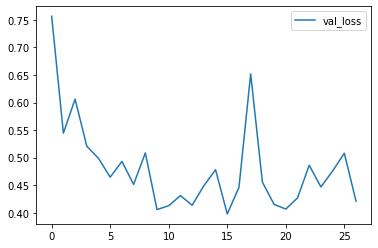

In [0]:
hist = pd.DataFrame({'cohen_kappa' : []})
fig, ax = plt.subplots()
for i in range(5):
  key = f'VAL_E{i}'
  history_df = pd.read_hdf(f'{DATASET_PATH}/history/from_imagenet_keras_history_full_2.hdf5', key=key)
  #ax.plot(history_df['batch'], history_df['cohen_kappa'], label=key)
  hist = pd.concat([hist, history_df], ignore_index=True)

for i in range(6, 28):
  #try:
    key = f'VAL_E{i}'

    history_df = pd.read_hdf(f'{DATASET_PATH}/history/from_imagenet_keras_history_full.hdf5', key=key)
    #ax.plot(history_df['batch'], history_df['cohen_kappa'], label=key)
    hist = pd.concat([hist, history_df], ignore_index=True)
  #except:
    #None

ax.plot(np.arange(hist.shape[0]), hist['val_loss'], label='val_loss')
ax.legend()
fig.show()
# print(hist['cohen_kappa'][40:20])

f = h5py.File(f'{DATASET_PATH}/history/from_imagenet_keras_history_full_2.hdf5', 'r')
print(list(f.keys()))
# print(pd.read_hdf(f'{DATASET_PATH}/history/from_imagenet_keras_history_full_1.hdf5', key='VAL_E1'))

# Evaluation and prediction

In [0]:
def classify(x):
  if x <= 0.8:
    return 0
  elif x > 0.8 and x <= 1.6:
    return 1
  elif x > 1.6 and x <= 2.4:
    return 2
  elif x > 2.4 and x <= 3.2:
    return 3
  elif x > 3.2:
    return 4

In [0]:
def classify05(x):
  if x < 0.5:
      return 0
  elif x < 1.5:
      return 1
  elif x < 2.5:
      return 2
  elif x < 3.5:
      return 3
  return 4

In [63]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE*2,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

y_predicted = []
y_true = []

progress = keras.utils.Progbar(target=len(validation_generator))

for i in range(len(validation_generator)):
  x, true_y = validation_generator[i]
  _predictions = model.predict(x)

  del x

  for j in range(len(_predictions)):
    class_p = int(classify05(_predictions[j]))
    class_t = int(true_y[j])
    y_predicted.append(class_p)
    y_true.append(class_t)
  
  progress.update(i)

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 29 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 13276 validated image filenames.
138/139 [============================>.] - ETA: 0s

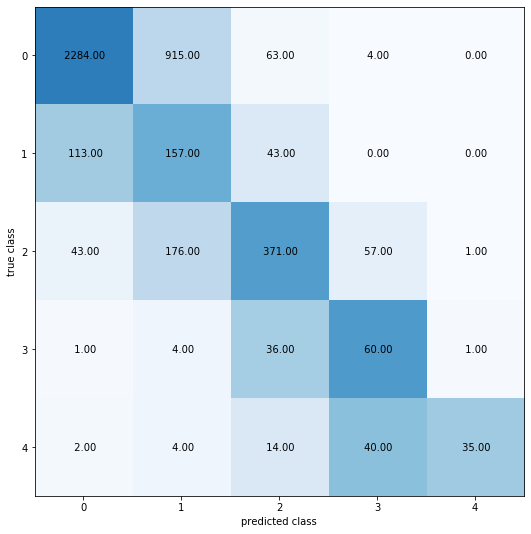

In [65]:
confusion_matrix = np.zeros((5, 5))

for i in range(len(y_predicted)):
  confusion_matrix[y_true[i], y_predicted[i]] += 1

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(confusion_matrix.astype(float) / confusion_matrix.sum(axis=1)[:, np.newaxis], cmap = plt.cm.Blues, vmax=1.0, vmin=0.0)
ax.set_xlabel('predicted class')
ax.set_ylabel('true class')

for (i, j), z in np.ndenumerate(confusion_matrix):
  ax.text(j, i, f'{z: 0.2f}', ha='center', va='center')

fig.show()

In [68]:
import sklearn.metrics

print('Kappa score: ', sklearn.metrics.cohen_kappa_score(y_true, y_predicted, weights='quadratic'))
print('Acurracy: ', sklearn.metrics.accuracy_score(y_true, y_predicted))

Kappa score:  0.7409261132215066
Acurracy:  0.6570976491862568
